In [ ]:
import numpy as np
import torch
import pandas as pd
import os, sys, math
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numpy.matlib import repmat
from scipy.io import loadmat
from functools import reduce
from operator import mul
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import shutil
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.matlib
import pdb
import scipy.stats
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%%capture
%cd /content/drive/MyDrive/11785FinalProject

In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1_-sXrJ8orknWrCpBjPBrDw_pPbOSjuMg/11785FinalProject'

In [ ]:
oslist = os.listdir("/root/LA/ASVspoof2019_LA_dev/flac")

FileNotFoundError: ignored

In [ ]:
%%capture
%cd /content/drive/MyDrive/11785FinalProject
!unzip dev_data.zip -d /root

In [ ]:
# Dataset construction / dataloading
class MelBankDataset(Dataset):
	def __init__(self, data, names, keys, crop_size, dtype, gender_dict=None, colname = None):
		self.data = data
		self.keys = keys
		self.names = names
		self.crop_size = crop_size
		self.dtype = dtype
		self.unit = np.dtype(dtype).itemsize
		self.EXTEND = True
		self.gender_dict = gender_dict
		self.gender = {'m':0, 'f':1}
		self.colname = colname

	def __len__(self):
		return len(self.data)
	
	def _read_feat(self, index):
		# Currently it is (time, frequency)
		## IMP ##
		## Check the dimension here. Im not sure whether it would be (Time, Freq) or (Freq, Time). 
		## Following function usage may change depending on this shape. Confirm before continuing.
		cqcc = np.load(self.file_list[index])
		return cqcc
		
	def _extend_feat(self, feat, EXTEND):
		height, width = (200, 40) # cqcc
		if EXTEND:
			B = repmat(feat,int(math.ceil(height/(feat.shape[0]))), 1)
			C = B.reshape(-1,width)
			D = C[:height,:]
		if not EXTEND: D = feat
		## normalizing ##
		frame_n = 300
		for s_pt in range(0, D.shape[0], frame_n):
			e_pt = min(s_pt+frame_n, D.shape[0])
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] - D[s_pt:e_pt, :].mean(axis=0)
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] / (D[s_pt:e_pt, :].std(axis=0)+np.finfo(np.float16).eps)
		D=D.astype('float32').transpose()[np.newaxis, ...]
		return D

	def __getitem__(self, index):
		basename = self.names[index][0]
		labels = self.keys[self.keys[self.colname]== basename]
		gend_label = self.gender_dict[labels.iloc[0].iloc[0]]
		if(gend_label == "u-m"):
			gend_label = "m"
		gender = self.gender[gend_label]
		device = 0 if labels.iloc[0].iloc[3] == "-" else 1
		data = self.data[index][0]
		data = self._extend_feat(data, self.EXTEND)
		return (basename, data, gender, device)

In [ ]:
train_names = np.load("/content/drive/MyDrive/11785FinalProject/data/train_names.npy")
train_data = np.load("/content/drive/MyDrive/11785FinalProject/data/train.npy", allow_pickle = True)
dev_names = np.load("/content/drive/MyDrive/11785FinalProject/data/dev_names.npy")
dev_data = np.load("/content/drive/MyDrive/11785FinalProject/data/dev.npy", allow_pickle = True)

In [ ]:
#Model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width
    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)

class ConvVAE(nn.Module):
    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(3,3), stride=(1,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 128, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,64, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            Flatten(),
            nn.Linear(64000, self.latent_size * 2),
            nn.ReLU()
        )
        # hidden => mu
        self.fc1 = nn.Linear( self.latent_size * 2, self.latent_size)
        # hidden => logvar
        self.fc2 = nn.Linear( self.latent_size * 2, self.latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size+1,  self.latent_size * 2),
            nn.ReLU(),
            nn.Linear( self.latent_size * 2, 64000),
            nn.ReLU(),
            Unflatten(64,  20 , 50),
            nn.ReLU(),
            nn.ConvTranspose2d(64,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=(3,4), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 1, kernel_size=(4,4), stride=(1,2), padding= (1,1)),
            nn.Sigmoid()
        )
    def encode(self, x, gender= None):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h) #logvar not actually log 
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def reparameterize_eval(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x, gender, do_cf = True):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) # (Batch size, latentsize)
        z1 = torch.cat((z, gender[:,None]), dim = 1) # (Batch size, latentsize + 1)
        cf_res =0
        if(do_cf): 
          counterfact = torch.cat((z, torch.logical_not(gender)[:,None]), dim = 1) # (batchsize, latentsize+1)
          cf_res = self.decode(counterfact)
        return self.decode(z1), cf_res, mu, logvar

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = ConvVAE(128)

In [ ]:
x = torch.empty((2,1,40,200))
a = model(x, torch.Tensor([0,0]))

In [ ]:
keys_t = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.train.trn.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
keys_d = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
keys_t = keys_t.rename(columns={'LA_0079': 'Speaker', 'LA_T_1138215': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
keys_d = keys_d.rename(columns={'LA_0069': 'Speaker', 'LA_D_1047731': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
keys = keys_t.append(keys_d, ignore_index=True)

In [ ]:
def filter_one(audio_data, names, keys, colname):
  rows = keys["bonafide"] == "bonafide"
  bona_files = []
  bona_names = []
  indices = keys.index
  bona_ind = indices[rows]
  for row in bona_ind:
    d = keys.iloc[row]
    filename= d.loc[colname] 
    where = np.where(names == filename)
    bona_files.append(audio_data[where])
    bona_names.append(names[where])

  rows2 = keys["bonafide"] != "bonafide"
  fake_ind = indices[rows2]
  fake_files = []
  fake_names = []
  for row in fake_ind:
    d = keys.iloc[row]
    filename= d.loc[colname]
    where = np.where(names == filename)
    fake_files.append(audio_data[where])
    fake_names.append(names[where])
  return bona_files, bona_names, fake_files, fake_names
 
data = np.concatenate((train_data, dev_data), axis = 0)
names = np.concatenate((train_names, dev_names), axis = 0)

b_files, b_names, f_files, f_names = filter_one(data, names, keys, colname = "Filename")


In [ ]:
#Train segment
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')

device = torch.device("cuda" if cuda else "cpu")

def pvalue(predicted, mean, var):
    z = (predicted - mean) / var
    pval = scipy.stats.norm.sf(np.abs(z))
    #If pval is less than 1-alpha, predict False. If pval >= 1-alpha, predict True (it is from the distribution)
    return pval


def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    rshape = recon_x.shape
    xshape = x.shape
    x = torch.softmax(x, 3)
    logvar = torch.exp(logvar)
    BCE = F.binary_cross_entropy(recon_x.view(-1, rshape[0] * rshape[1]*rshape[2]*rshape[3]), (x.view(-1, xshape[0]*xshape[1]*xshape[2]*xshape[3])), reduction = "mean")
    RMSE = torch.sqrt(F.binary_cross_entropy(recon_x.view(rshape[0], rshape[1]*rshape[2]*rshape[3]), x.view(xshape[0], xshape[2]*xshape[1]*xshape[3]), reduction = "none").mean(dim = 1))

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, RMSE.detach().cpu().numpy()

### Training #####
def train(epoch, model, train_loader, optimizer, args, device):
    mse = nn.MSELoss()
    model.train()
    train_loss = 0
    rmse_real, rmse_fake = [], []
    gender0mse, gender1mse = 0,0
    num_zeros, num_ones = 1,1
    for batch_idx, (basename, data, gender, device_) in enumerate(train_loader):
        data,gender = data.to(device), gender.to(device)
        optimizer.zero_grad()
        recon_batch, counter_factual, mu, logvar = model(data, gender)
        zeros = (gender == 0)
        ones = (gender == 1)

        num_zeros += len(zeros)
        num_ones += len(ones)
        loss, rmse = loss_function(recon_batch, data, mu, logvar)
        rmse_real.extend(rmse)
        nan_count = torch.sum(torch.isnan(recon_batch))
        if(nan_count.item() != 0):
          pdb.set_trace()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    gender0mse /= num_zeros
    gender1mse /= num_ones

    del gender
    del data
    del recon_batch
    del mu
    del logvar
    del loss
    del rmse
    del zeros
    del ones
    return train_loss, np.asarray(rmse_real), gender0mse, gender1mse

### Validating ####
def test(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    percentile_val = np.percentile(rmse_real, threshold)
    print("percentile info: ", "threshold: ", round(percentile_val,5), "mean: ", round(np.mean(rmse_real),5))
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    rmse_fake_f, rmse_fake_m = [],[]
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)
            ones = (gender == 1)
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)

            zeros_g = (gender == 0).nonzero().detach().numpy()
            ones_g = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros_g].tolist())
            rmse_female.extend(rmse[ones_g].tolist())

            zeros_d = (device_ == 0).nonzero().detach().numpy()
            ones_d = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros_d].tolist())
            rmse_1.extend(rmse[ones_d].tolist())

            female_fake = np.intersect1d(ones_d, ones_g)
            male_fake = np.intersect1d(ones_d, zeros_g)
            rmse_fake_f.extend(rmse[female_fake])
            rmse_fake_m.extend(rmse[male_fake])
            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona
            acc = (pred == device_).float().sum()
            f1_score = metrics.f1_score(device_, pred)
            test_loss += loss.item()
            test_acc += acc.item()
            test_f1 += f1_score
            total += data.shape[0]

    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros

    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female, rmse_fake_m, rmse_fake_f

def valid(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    percentile_val = np.percentile(rmse_real, threshold)
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)
            ones = (gender == 1)
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)
            zeros = (gender == 0).nonzero().detach().numpy()
            ones = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros].tolist())
            rmse_female.extend(rmse[ones].tolist())


            zeros = (device_ == 0).nonzero().detach().numpy()
            ones = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros].tolist())
            rmse_1.extend(rmse[ones].tolist())

            
            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona

            acc = (pred == device_).float().sum()
            test_loss += loss.item()
            test_acc += acc.item()
            total += data.shape[0]

    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros
    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female

cuda available


percentile info:  threshold:  1.00545 mean:  0.8014
test rmse info: 0std: 0.00179, 0mean: 0.222411, 1std: 0.00179, 1mean: 0.221964, mean_diff: -0.00045
Epoch [1/20] loss: 25.58662 val_loss: 15.79070 gender0 mse: 0.22092 gender1mse: 0.22260 threshold: 65  f1: 0.0000000   train_acc:1.00000   test_acc: 0.0222241
0.2209169 0.22258553
****************************** Learning Rate:  2e-05 ******************************


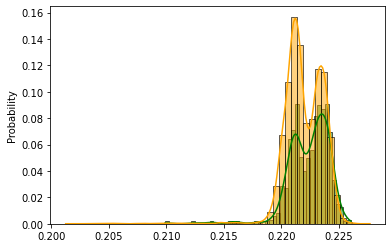

percentile info:  threshold:  0.21653 mean:  0.21426
test rmse info: 0std: 0.00115, 0mean: 0.19456, 1std: 0.00134, 1mean: 0.194463, mean_diff: -0.0001
Epoch [2/20] loss: 6.95169 val_loss: 1.14157 gender0 mse: 0.19294 gender1mse: 0.19537 threshold: 65  f1: 0.0000000   train_acc:1.00000   test_acc: 0.0222241
0.19293527 0.19536954
****************************** Learning Rate:  2e-05 ******************************


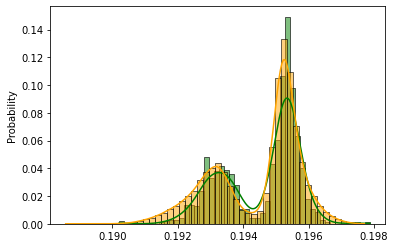

percentile info:  threshold:  0.18598 mean:  0.18536
test rmse info: 0std: 0.00088, 0mean: 0.18395, 1std: 0.00107, 1mean: 0.184486, mean_diff: 0.00054
Epoch [3/20] loss: 0.30709 val_loss: 0.14341 gender0 mse: 0.18536 gender1mse: 0.18395 threshold: 65  f1: 0.1578314   train_acc:0.99683   test_acc: 0.1068711
0.1853726 0.18395975
****************************** Learning Rate:  2e-05 ******************************


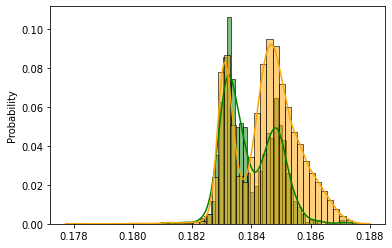

percentile info:  threshold:  0.18181 mean:  0.18144
test rmse info: 0std: 0.00097, 0mean: 0.180674, 1std: 0.00143, 1mean: 0.181598, mean_diff: 0.00092
Epoch [4/20] loss: 0.14300 val_loss: 0.17014 gender0 mse: 0.18232 gender1mse: 0.18114 threshold: 65  f1: 0.6108268   train_acc:0.94952   test_acc: 0.4536112
0.1823378 0.18115936
****************************** Learning Rate:  2e-05 ******************************


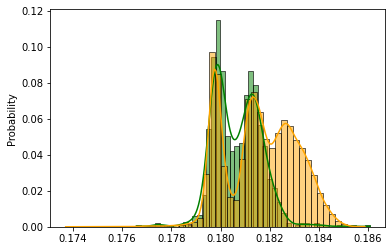

percentile info:  threshold:  0.18035 mean:  0.18005
test rmse info: 0std: 0.00115, 0mean: 0.179156, 1std: 0.00199, 1mean: 0.180546, mean_diff: 0.00139
Epoch [5/20] loss: 0.13350 val_loss: 0.08904 gender0 mse: 0.18112 gender1mse: 0.18015 threshold: 65  f1: 0.6799227   train_acc:0.93026   test_acc: 0.5271568
0.18115203 0.18018691
****************************** Learning Rate:  2e-05 ******************************


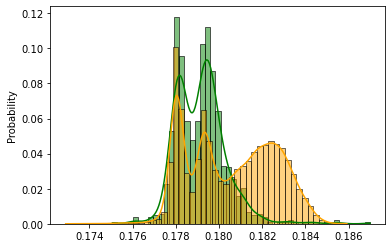

percentile info:  threshold:  0.1794 mean:  0.17913
test rmse info: 0std: 0.00136, 0mean: 0.178358, 1std: 0.0025, 1mean: 0.180139, mean_diff: 0.00178
Epoch [6/20] loss: 0.11310 val_loss: 0.08055 gender0 mse: 0.18057 gender1mse: 0.17982 threshold: 65  f1: 0.6998391   train_acc:0.88881   test_acc: 0.5492509
0.18060508 0.17986172
****************************** Learning Rate:  2e-05 ******************************


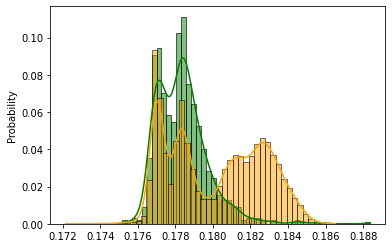

percentile info:  threshold:  0.1787 mean:  0.17846
test rmse info: 0std: 0.00155, 0mean: 0.177686, 1std: 0.00293, 1mean: 0.179815, mean_diff: 0.00213
Epoch [7/20] loss: 0.09830 val_loss: 0.08856 gender0 mse: 0.18020 gender1mse: 0.17951 threshold: 65  f1: 0.7031313   train_acc:0.86418   test_acc: 0.5529152
0.1802455 0.17955919
****************************** Learning Rate:  2e-05 ******************************


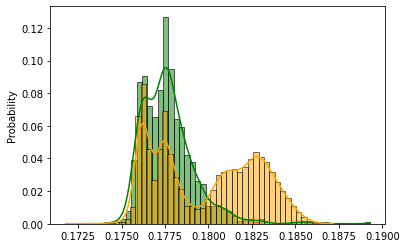

percentile info:  threshold:  0.17816 mean:  0.17797
test rmse info: 0std: 0.00163, 0mean: 0.177293, 1std: 0.00323, 1mean: 0.179688, mean_diff: 0.00239
Epoch [8/20] loss: 0.08912 val_loss: 0.06984 gender0 mse: 0.18001 gender1mse: 0.17941 threshold: 65  f1: 0.7069395   train_acc:0.85321   test_acc: 0.5573600
0.1800581 0.17946824
****************************** Learning Rate:  2e-05 ******************************


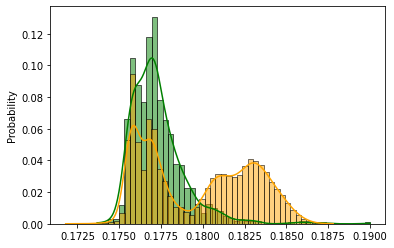

percentile info:  threshold:  0.17775 mean:  0.17757
test rmse info: 0std: 0.00175, 0mean: 0.176883, 1std: 0.00352, 1mean: 0.179512, mean_diff: 0.00263
Epoch [9/20] loss: 0.08314 val_loss: 0.06427 gender0 mse: 0.17976 gender1mse: 0.17927 threshold: 65  f1: 0.7090721   train_acc:0.84540   test_acc: 0.5596800
0.17981361 0.17933351
****************************** Learning Rate:  2e-05 ******************************


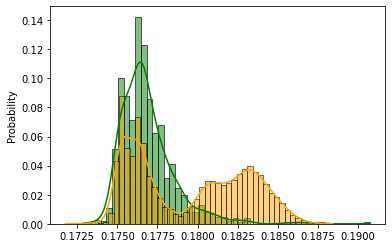

percentile info:  threshold:  0.17743 mean:  0.17725
test rmse info: 0std: 0.0018, 0mean: 0.176653, 1std: 0.00364, 1mean: 0.179365, mean_diff: 0.00271
Epoch [10/20] loss: 0.07223 val_loss: 0.05421 gender0 mse: 0.17964 gender1mse: 0.17910 threshold: 65  f1: 0.7130628   train_acc:0.82833   test_acc: 0.5642983
0.17969503 0.1791683
****************************** Learning Rate:  2e-05 ******************************


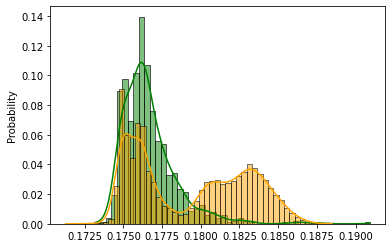

percentile info:  threshold:  0.17712 mean:  0.17697
test rmse info: 0std: 0.00178, 0mean: 0.176463, 1std: 0.00371, 1mean: 0.179269, mean_diff: 0.00281
Epoch [11/20] loss: 0.06796 val_loss: 0.07230 gender0 mse: 0.17951 gender1mse: 0.17902 threshold: 65  f1: 0.7166264   train_acc:0.82321   test_acc: 0.5682444
0.17956902 0.17909017
****************************** Learning Rate:  2e-05 ******************************


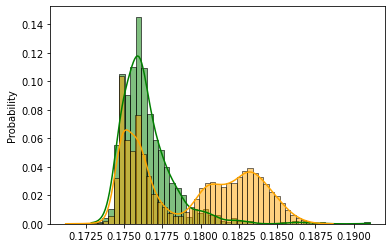

percentile info:  threshold:  0.17694 mean:  0.17678
test rmse info: 0std: 0.00177, 0mean: 0.176333, 1std: 0.00376, 1mean: 0.179194, mean_diff: 0.00286
Epoch [12/20] loss: 0.06615 val_loss: 0.07290 gender0 mse: 0.17943 gender1mse: 0.17895 threshold: 65  f1: 0.7173479   train_acc:0.81907   test_acc: 0.5690683
0.17948546 0.17902078
****************************** Learning Rate:  2e-05 ******************************


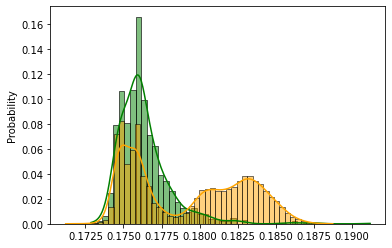

percentile info:  threshold:  0.17674 mean:  0.17661
test rmse info: 0std: 0.00189, 0mean: 0.176012, 1std: 0.00389, 1mean: 0.178957, mean_diff: 0.00295
Epoch [13/20] loss: 0.06226 val_loss: 0.04977 gender0 mse: 0.17919 gender1mse: 0.17871 threshold: 65  f1: 0.7151857   train_acc:0.82175   test_acc: 0.5666399
0.17925444 0.1787806
****************************** Learning Rate:  2e-05 ******************************


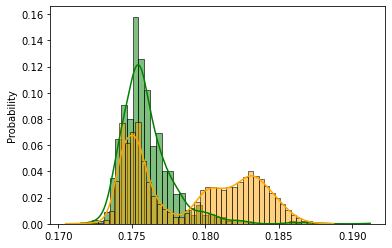

percentile info:  threshold:  0.17654 mean:  0.17642
test rmse info: 0std: 0.00185, 0mean: 0.175929, 1std: 0.00389, 1mean: 0.178888, mean_diff: 0.00296
Epoch [14/20] loss: 0.05717 val_loss: 0.04380 gender0 mse: 0.17907 gender1mse: 0.17868 threshold: 65  f1: 0.7185667   train_acc:0.81102   test_acc: 0.5702825
0.1791281 0.17874564
****************************** Learning Rate:  2e-05 ******************************


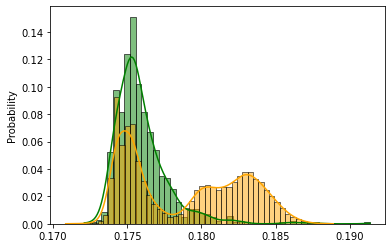

percentile info:  threshold:  0.1764 mean:  0.17626
test rmse info: 0std: 0.00192, 0mean: 0.175729, 1std: 0.00398, 1mean: 0.178746, mean_diff: 0.00302
Epoch [15/20] loss: 0.05112 val_loss: 0.03773 gender0 mse: 0.17890 gender1mse: 0.17855 threshold: 65  f1: 0.7162469   train_acc:0.81102   test_acc: 0.5674855
0.17896065 0.17861806
****************************** Learning Rate:  2e-05 ******************************


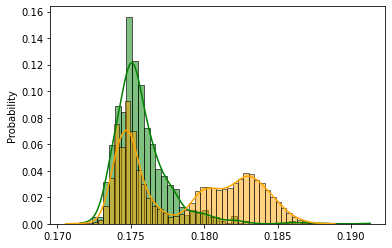

percentile info:  threshold:  0.17624 mean:  0.17613
test rmse info: 0std: 0.00194, 0mean: 0.175702, 1std: 0.00398, 1mean: 0.178717, mean_diff: 0.00301
Epoch [16/20] loss: 0.05014 val_loss: 0.07402 gender0 mse: 0.17894 gender1mse: 0.17848 threshold: 65  f1: 0.7222596   train_acc:0.80102   test_acc: 0.5747924
0.17899948 0.1785488
****************************** Learning Rate:  2e-05 ******************************


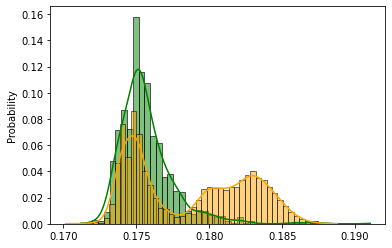

percentile info:  threshold:  0.17618 mean:  0.17605
test rmse info: 0std: 0.0019, 0mean: 0.175635, 1std: 0.00397, 1mean: 0.178644, mean_diff: 0.00301
Epoch [17/20] loss: 0.05064 val_loss: 0.04683 gender0 mse: 0.17885 gender1mse: 0.17842 threshold: 65  f1: 0.7215251   train_acc:0.80322   test_acc: 0.5737733
0.17891134 0.17848521
****************************** Learning Rate:  2e-05 ******************************


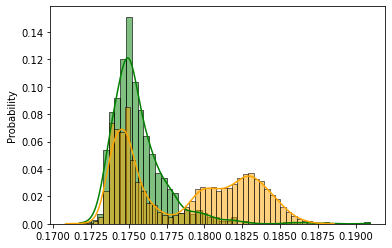

percentile info:  threshold:  0.17604 mean:  0.17592
test rmse info: 0std: 0.00192, 0mean: 0.175536, 1std: 0.00399, 1mean: 0.178564, mean_diff: 0.00303
Epoch [18/20] loss: 0.04610 val_loss: 0.05507 gender0 mse: 0.17875 gender1mse: 0.17834 threshold: 65  f1: 0.7226944   train_acc:0.79907   test_acc: 0.5750526
0.17881711 0.17841332
****************************** Learning Rate:  2e-05 ******************************


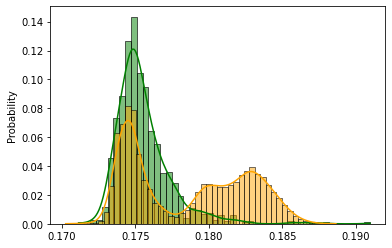

percentile info:  threshold:  0.17594 mean:  0.17582
test rmse info: 0std: 0.00189, 0mean: 0.175425, 1std: 0.00398, 1mean: 0.178452, mean_diff: 0.00303
Epoch [19/20] loss: 0.04293 val_loss: 0.03333 gender0 mse: 0.17861 gender1mse: 0.17825 threshold: 65  f1: 0.7215150   train_acc:0.80200   test_acc: 0.5739034
0.17867084 0.17832164
****************************** Learning Rate:  2e-05 ******************************


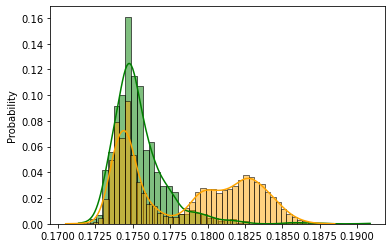

percentile info:  threshold:  0.17586 mean:  0.17574
test rmse info: 0std: 0.00192, 0mean: 0.175343, 1std: 0.00403, 1mean: 0.178416, mean_diff: 0.00307
Epoch [20/20] loss: 0.04160 val_loss: 0.04529 gender0 mse: 0.17855 gender1mse: 0.17823 threshold: 65  f1: 0.7208664   train_acc:0.79615   test_acc: 0.5730361
0.17861412 0.1782989
****************************** Learning Rate:  2e-05 ******************************


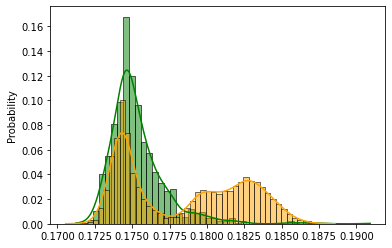

{65: 20}


In [ ]:
def save_checkpoint(state, is_best, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    checkpoint_file = os.path.join(outdir, 'checkpoint.pth')
    best_file = os.path.join(outdir, 'model_best.pth')
    torch.save(state, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, best_file)



def main(train_data, train_names, dev_data, dev_names):
    parser = argparse.ArgumentParser(description='Explainable VAE MNIST Example')
    parser.add_argument('--ckpt_dir', type=str, default='/content/drive/MyDrive/11785FinalProject/results/ckpt.pt', metavar='DIR',
                        help='ckpt directory')
    parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--resume', default=True, type=str, metavar='PATH',
                        help='path to latest checkpoint (default: None')

    # model options
    parser.add_argument('--latent_size', type=int, default=128, metavar='N',
                        help='latent vector size of encoder')
    parser.add_argument('--one_class', type=int, default=3, metavar='N',
                        help='inlier digit for one-class VAE training')
    parser.add_argument("--fake", type = int, default = 0, metavar = 'N', help = "d")

    args, unknown = parser.parse_known_args()

    torch.manual_seed(args.seed)
    train_gender_dict = {'LA_0079': 'f', 'LA_0098': 'f', 'LA_0089': 'u-m', 'LA_0088': 'f', 'LA_0087': 'f', 'LA_0086': 'f', 'LA_0085': 'f', 'LA_0084': 'f', 'LA_0083': 'm', 'LA_0082': 'm', 'LA_0081': 'f', 'LA_0080': 'f', 'LA_0090': 'f', 'LA_0097': 'f', 'LA_0092': 'm', 'LA_0095': 'm', 'LA_0094': 'u-m', 'LA_0093': 'm', 'LA_0096': 'm', 'LA_0091': 'f'}
    dev_gender_dict = {'LA_0069': 'f', 'LA_0070': 'm', 'LA_0071': 'm', 'LA_0072': 'f', 'LA_0073': 'm', 'LA_0074': 'f', 'LA_0075': 'f', 'LA_0076': 'm', 'LA_0077': 'f', 'LA_0078': 'f', 'LA_0099': 'm', 'LA_0100': 'm', 'LA_0101': 'm', 'LA_0102': 'f', 'LA_0103': 'f', 'LA_0104': 'f', 'LA_0105': 'm', 'LA_0106': 'f', 'LA_0107': 'f', 'LA_0108': 'f'}

    gender_dict = {**train_gender_dict, **dev_gender_dict}

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

    #t_f_files: train fake files
    #t_b_files: train bonafide files
    #d_f_files: dev fake files
    #d_b_files: dev bonafide files
    val_ratio = 0.2
    torch.cuda.empty_cache()
    #For training on Bonafide
    train_data = MelBankDataset(b_files, b_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valid_data = MelBankDataset(f_files, f_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valids = int(len(train_data) * val_ratio)
    train_data, valid_data_b = torch.utils.data.random_split(train_data, [len(train_data) - valids, valids])

    valids = int(len(valid_data) * 0.3)
    valid_data_f, unused = torch.utils.data.random_split(valid_data, [len(valid_data) - valids, valids])

    combined_val = torch.utils.data.ConcatDataset([valid_data_b, valid_data])
    
    """
    #For training on Fake
    valid_data = MelBankDataset(b_files, b_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    train_data = MelBankDataset(f_files, f_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")

    valids = int(len(train_data) * val_ratio * 1.5)
    train_data, valid_data_f = torch.utils.data.random_split(train_data, [len(train_data) - valids, valids])

    combined_val = torch.utils.data.ConcatDataset([valid_data, valid_data_f]) """

    """only use portion of fake data because there are 10 times more fake data than bonafide"""

    path = "/content/drive/MyDrive/11785FinalProject/model1.pt"
    
    train_loader = DataLoader(train_data, batch_size= args.batch_size, num_workers = 4, shuffle = True)
    val_loader = DataLoader(combined_val, batch_size = args.batch_size, shuffle = True, num_workers = 4)

    model = ConvVAE(args.latent_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    retrieve_model =False

    if(retrieve_model):
      checkpoint = torch.load(path)
      model.load_state_dict(checkpoint["model_state_dict"])
      optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    start_epoch = 0
    best_test_loss = np.finfo('f').max
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3, factor = 0.5)
    # optionally resume from a checkpoint
    """if args.resume:
        if os.path.isfile(args.resume):
            print('=> loading checkpoint %s' % args.resume)
            checkpoint = 
            checkpoint = torch.load(args.resume)
            start_epoch = checkpoint['epoch'] + 1
            best_test_loss = checkpoint['best_test_loss']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('=> loaded checkpoint %s' % args.resume)
        else:
            print('=> no checkpoint found at %s' % args.resume)"""

    best_loss = 100
    thresholds = [65] # [75,80,85]
    dic = dict()
    test_accs,train_accs, test_f1s, train_f1s = dict(),[],dict(),[]
    train_losses, test_losses = [], dict()
    rmse_real_list, rmse_fake_list = dict(), dict()
    mean_diffs = dict()

    for epoch in range(start_epoch, args.epochs):
        thres = 75
        train_loss,rmse_real, g0mse, g1mse = train(epoch, model, train_loader, optimizer, args, device)
        _,valid_acc, _, _, _, _ ,_, _,_, _ = valid(epoch, model, train_loader,args, rmse_real, device, thres)
        cur_acc = 0
        for thres in thresholds:
          test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_ ,g0mse, g1mse,rmse_male, rmse_female, rmse_fake_m, rmse_fake_f = test(epoch, model, val_loader,args, rmse_real, device, thres)
          if(thres not in test_accs):
            test_f1s[thres] = [f1]
            rmse_fake_list[thres] = [rmse_fake]
            rmse_real_list[thres] = [rmse_real]
            test_losses[thres] = [test_loss]
            test_accs[thres] =[test_acc]
          else:
            test_accs[thres].append(test_acc)
            test_f1s[thres].append(f1)
            rmse_fake_list[thres].append(rmse_fake)
            rmse_real_list[thres].append(rmse_real)
            test_losses[thres].append(test_loss)
          if(test_acc > cur_acc):
            epoch_loss, epoch_acc, epoch_auc, epoch_f1, epoch_rmse_fake, epoch_rmse_real, epoch_g0mse, epoch_g1mse,e_rmse_male, e_rmse_female = test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_, g0mse, g1mse,rmse_male, rmse_female
            best_thres = thres
            cur_acc = test_acc

        if(best_thres in dic):
          dic[best_thres] +=1
        else:
          dic[best_thres] = 1
        flat_male = [item for sublist in e_rmse_male for item in sublist]
        flat_female = [item for sublist in e_rmse_female for item in sublist]
        print("test rmse info: 0std: {}, 0mean: {}, 1std: {}, 1mean: {}, mean_diff: {}".format(round(np.std(epoch_rmse_real),5), round(np.mean(epoch_rmse_real),6), round(np.std(epoch_rmse_fake),5), round(np.mean(epoch_rmse_fake),6), round(np.mean(epoch_rmse_fake)-np.mean(epoch_rmse_real), 5)))
        print('Epoch [%d/%d] loss: %.5f val_loss: %.5f gender0 mse: %.5f gender1mse: %.5f threshold: %d  f1: %.7f   train_acc:%.5f   test_acc: %.7f' % (epoch + 1, args.epochs, train_loss, epoch_loss, np.mean(flat_male), np.mean(flat_female),best_thres, epoch_f1, valid_acc, epoch_acc))
        print(np.asarray(rmse_fake_m).mean(), np.asarray(rmse_fake_f).mean())
        print("**" * 15, "Learning Rate: ", optimizer.param_groups[0]['lr'], "**" * 15)

        flat_real = [item for sublist in epoch_rmse_real for item in sublist]
        flat_fake = [item for sublist in epoch_rmse_fake for item in sublist]
        plt.clf()
        sns.histplot(data=flat_real, bins = 50, stat = "probability", color = "Green", kde = True)
        sns.histplot(data = flat_fake, bins = 50, stat = "probability", color = "Orange", kde = True)
        plt.show()

        train_accs.append(valid_acc)

        train_losses.append(train_loss)

        if(test_loss < best_loss):
          torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
          best_loss= test_loss

        scheduler.step(test_loss)

    print(dic)
    return rmse_real_list, rmse_fake_list, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses

    """ Visualize sample validation result 
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        img = make_grid(sample)
        save_dir = os.path.join('./',args.result_dir)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir) 
        save_image(sample.view(64, 1, 28, 28), os.path.join(save_dir,'sample_' + str(epoch) + '.png'))"""


rmse_real, rmse_fake, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses = main(train_data, train_names, dev_data, dev_names)